# **MACHINE LEARNING**
---
### Thông tin nhóm:
- STT nhóm: 10

|MSSV|Họ và tên|
|:---|:--------|
|18120066|Bùi Đoàn Hữu Nhân|
|18120085|Nguyễn Tấn Thìn|
|18120090|Phạm Nguyên Minh Thy|
|18120097|Đinh Hữu Phúc Trung|
|18120649|Nguyễn Phạm Phúc Việt|


# **LAB02 - CLASSIFICATION**

### Yêu cầu:
- Phân tích kỹ bài toán tập và tập dữ liệu hình ảnh được cung cấp và tập dữ
liệu đã được xác định được loại bệnh `train.csv` và `test.csv`. Chọn lựa và
trình bày kiểu mạng Nơron để giải quyết bài toán.
- Cài đặt các thuật toán mạng Nơron đã được học để xác định loại bệnh đang có trên cây trồng.
- Báo cáo kết quả đạt đưoc sau quá trình phân tích và cài đặt.

## **Import**

In [ ]:
!pip install efficientnet
!pip install tensorflow-addons=='0.9.1'
import efficientnet.tfkeras as efn

import time
import pandas as pd
import cv2
import numpy as np
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential , Model
from tensorflow.keras.layers import Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization, Input, add
from tensorflow.keras.callbacks import ModelCheckpoint

import os
from tensorflow.keras import optimizers

print(tf.__version__)
print(tf.keras.__version__)

from tensorflow.keras.applications.inception_v3 import InceptionV3

     |████████████████████████████████| 51kB 2.1MB/s 
     |████████████████████████████████| 1.0MB 3.9MB/s 
2.5.0
2.5.0


## **Data Observation**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
sample_submission = pd.read_csv("/content/gdrive/My Drive/Machine Learning/data/sample_submission.csv")
test = pd.read_csv("/content/gdrive/My Drive/Machine Learning/data/test.csv")
train = pd.read_csv("/content/gdrive/My Drive/Machine Learning/data/train.csv")

In [ ]:
train.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [ ]:
test.head()

,image_id
0,Test_0
1,Test_1
2,Test_2
3,Test_3
4,Test_4


In [ ]:
print(train.shape)
print(test.shape)

(1821, 5)
(1821, 1)


### Training Data

In [ ]:
train_images = []
for name in train['image_id'] :
    path = '/content/gdrive/My Drive/Machine Learning/data/images/'+name+'.jpg'
    image = cv2.imread(path)
    image=cv2.resize(image,(img_size,img_size),interpolation=cv2.INTER_AREA)
    train_images.append(image)

(1365, 2048, 3)


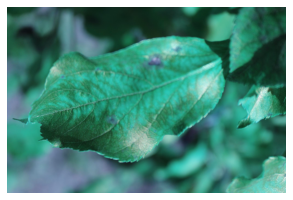

In [ ]:
img_path = '/content/gdrive/My Drive/Machine Learning/data/images/Train_0.jpg'
img = cv2.imread(img_path)
print(img.shape)
plt.figure(figsize=(5, 5))
plt.axis('off')
plt.imshow(img)
plt.show()

In [ ]:
y = train.drop('image_id',axis=1)
y = np.array(y)
y.shape

(1821, 4)

### Test Data

In [ ]:
test_images = []
for name in test['image_id'] :
    image = cv2.imread('/content/gdrive/My Drive/Machine Learning/data/images/'+name+'.jpg')
    image=cv2.resize(image,(img_size,img_size),interpolation=cv2.INTER_AREA)
    test_images.append(image)

(1365, 2048, 3)


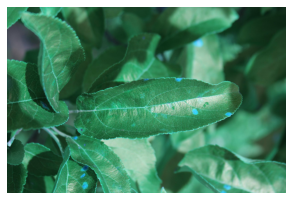

In [ ]:
img_path = '/content/gdrive/My Drive/Machine Learning/data/images/Test_0.jpg'
img = cv2.imread(img_path)
print(img.shape)
plt.figure(figsize=(5, 5))
plt.axis('off')
plt.imshow(img)
plt.show()

## **Preprocessing Data**

In [ ]:
img_size = 300

In [ ]:
X = np.ndarray(shape=(len(train_images),img_size,img_size,3),dtype=np.float32)

for i,image in enumerate(train_images) :
    X[i] = image
    
X = X/255.0    
X.shape    

In [ ]:
X_test = np.ndarray(shape=(len(test_images),img_size,img_size,3),dtype=np.float32)

for i,image in enumerate(test_images) :
    X_test[i]=image

X_test = X_test / 255.0  
X_test.shape

In [ ]:
# # Nhóm tiến hành lưu 2 mảng X và X_test vào file numpy
# # để mỗi khi chạy lại không cần preprocess data lại nữa
# train_numpy_path = "/content/gdrive/My Drive/Machine Learning/data/train_file.npy"
# test_numpy_path = "/content/gdrive/My Drive/Machine Learning/data/test_file.npy"
# X = np.load(train_numpy_path)
# X_test = np.load(test_numpy_path)

In [ ]:
data_gen = ImageDataGenerator(rotation_range=45,
                              horizontal_flip=True,
                              vertical_flip=True,
                              width_shift_range=0.2,
                              height_shift_range=0.2,
                              zoom_range = 0.1,
                              shear_range = 0.1,
                              fill_mode = 'nearest'
                             )
data_gen.fit(X)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
print(X_train.shape)
print(X_val.shape)

(1456, 300, 300, 3)
(365, 300, 300, 3)


## **Model checkpoint**

In [ ]:
model_vgg_path = '/content/gdrive/My Drive/Machine Learning/data/best_model_vgg.h5'
checkpoint_vgg = ModelCheckpoint(model_vgg_path, monitor = 'val_loss' , mode = 'min', verbose = 1 , save_best_only = True)

model_resnet_path = '/content/gdrive/My Drive/Machine Learning/data/best_model_resnet50.h5'
checkpoint_resnet = ModelCheckpoint(model_resnet_path, monitor = 'val_loss' , mode = 'min', verbose = 1 , save_best_only = True)

model_inception_path = '/content/gdrive/My Drive/Machine Learning/data/best_model_inceptionV3.h5'
checkpoint_inception = ModelCheckpoint(model_inception_path, monitor = 'val_loss' , mode = 'min', verbose = 1 , save_best_only = True)

model_mlp_path = '/content/gdrive/My Drive/Machine Learning/data/best_model_mlp.h5'
checkpoint_mlp = ModelCheckpoint(model_mlp_path, monitor = 'val_loss' , mode = 'min', verbose = 1 , save_best_only = True)

model_eff_path = '/content/gdrive/My Drive/Machine Learning/data/best_model_eff.h5'
checkpoint_eff = ModelCheckpoint(model_eff_path, monitor = 'val_loss' , mode = 'min', verbose = 1 , save_best_only = True)

model_resnet1_path = '/content/gdrive/My Drive/Machine Learning/data/best_model_resnet_50.h5'
checkpoint_resnet1 = ModelCheckpoint(model_resnet1_path, monitor = 'val_loss' , mode = 'min', verbose = 1 , save_best_only = True)

## **Additional Function**

In [ ]:
def plot_performance(history, name_chart, size) :
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    t = f.suptitle(name_chart, fontsize=12)
    f.subplots_adjust(top=0.85, wspace=0.3)

    epoch_list = list(range(1,size + 1))
    ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
    ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_xticks(np.arange(0, size + 1, 5))
    ax1.set_ylabel('Accuracy Value')
    ax1.set_xlabel('Epoch')
    ax1.set_title('Accuracy')
    l1 = ax1.legend(loc="best")

    ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
    ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
    ax2.set_xticks(np.arange(0, size + 1, 5))
    ax2.set_ylabel('Loss Value')
    ax2.set_xlabel('Epoch')
    ax2.set_title('Loss')
    l2 = ax2.legend(loc="best")

In [ ]:
def confusion_matrix(model, X, Y):
    y_preds = model.predict(X)
    y_test = np.argmax(Y, axis=1)
    y_pred = np.argmax(y_preds, axis=1)
    
    from sklearn.metrics import confusion_matrix
    confusion = confusion_matrix(y_test, y_pred)
    print('Confusion Matrix\n')
    print(confusion)

    from sklearn.metrics import classification_report
    print('\nClassification Report\n')
    print(classification_report(y_test, y_pred, target_names=['healthy', 'multiple_diseases', 'rust', 'scab']))

## **Neural Networks**

### MLP

In [ ]:
def construct_model_MLP() :
    model = Sequential()

    model.add(Flatten(input_shape=(img_size, img_size, 3)))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(70, activation='relu'))
    model.add(Dense(40,activation='relu'))
    model.add(Dense(4,activation='softmax'))

    model.compile(optimizer='Adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])
    
    return model  

In [ ]:
model = construct_model_MLP()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 270000)            0         
_________________________________________________________________
dense (Dense)                (None, 100)               27000100  
_________________________________________________________________
dense_1 (Dense)              (None, 70)                7070      
_________________________________________________________________
dense_2 (Dense)              (None, 40)                2840      
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 164       
Total params: 27,010,174
Trainable params: 27,010,174
Non-trainable params: 0
_________________________________________________________________


In [ ]:
start_time = time.time()
history = model.fit_generator(data_gen.flow(X_train,Y_train,batch_size=32),
                    steps_per_epoch = X_train.shape[0] // 32,
                    epochs = 100,
                    verbose = True,
                    validation_data= (X_val,Y_val),
                    callbacks = [checkpoint_mlp]
                   )
end_time = time.time()
print('Run time: %f ms' % ((end_time - start_time) * 1000))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
45/45 [==============================] - 22s 492ms/step - loss: 1.4976 - accuracy: 0.3581 - val_loss: 1.2709 - val_accuracy: 0.3699

Epoch 00001: val_loss improved from 1.32838 to 1.27094, saving model to /content/gdrive/My Drive/Machine Learning/data/best_model_mlp.h5
Epoch 2/100
45/45 [==============================] - 23s 501ms/step - loss: 1.2916 - accuracy: 0.3708 - val_loss: 1.2858 - val_accuracy: 0.3781

Epoch 00002: val_loss did not improve from 1.27094
Epoch 3/100
45/45 [==============================] - 22s 500ms/step - loss: 1.4138 - accuracy: 0.3666 - val_loss: 1.4073 - val_accuracy: 0.3370

Epoch 00003: val_loss did not improve from 1.27094
Epoch 4/100
45/45 [==============================] - 22s 497ms/step - loss: 1.3871 - accuracy: 0.3638 - val_loss: 1.6815 - val_accuracy: 0.3178

Epoch 00004: val_loss did not improve from 1.27094
Epoch 5/100
45/45 [==============================] - 22s 496ms/step - loss: 1.5377 - accuracy: 0.3596 - val_loss: 10.2045 - val_ac

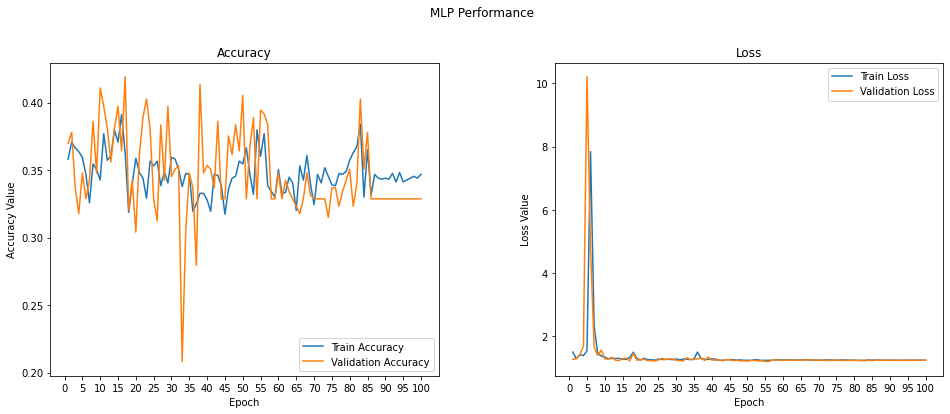

In [ ]:
plot_performance(history, "MLP Performance", 100)

In [ ]:
model = construct_model_MLP()
model.load_weights(model_mlp_path)

In [ ]:
model.evaluate(data_gen.flow(X_train,Y_train,batch_size=32))

46/46 [==============================] - 22s 485ms/step - loss: 1.2153 - accuracy: 0.3839


[1.2153109312057495, 0.3839285671710968]

In [ ]:
model.evaluate(X_val,Y_val)

12/12 [==============================] - 0s 17ms/step - loss: 1.1973 - accuracy: 0.3918


[1.197313666343689, 0.391780823469162]

In [ ]:
predictions = model.predict(X_test)
df_pred  = pd.DataFrame(predictions, columns = ['healthy','multiple_diseases','rust','scab'])
results = {'image_id' : test.image_id,
            'healthy' : df_pred.healthy,
            'multiple_diseases' : df_pred.multiple_diseases,
            'rust' : df_pred.rust,
            'scab' : df_pred.scab
          }
df_results_cnn = pd.DataFrame(results)
df_results_cnn.to_csv('submissionMLP.csv',index=False) #0.926

In [ ]:
confusion_matrix(model, X_val, Y_val)

Confusion Matrix

[[ 43   0  57   0]
 [  0   0  18   0]
 [ 20   0 100   0]
 [ 19   0 108   0]]

Classification Report

                   precision    recall  f1-score   support

          healthy       0.52      0.43      0.47       100
multiple_diseases       0.00      0.00      0.00        18
             rust       0.35      0.83      0.50       120
             scab       0.00      0.00      0.00       127

         accuracy                           0.39       365
        macro avg       0.22      0.32      0.24       365
     weighted avg       0.26      0.39      0.29       365



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### VGG16

In [ ]:
def construct_model_VGG16() :
    model = Sequential()
    
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(img_size,img_size,3)))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(1000,activation='relu'))
    model.add(Dense(4,activation='softmax'))
    
    model.compile(optimizer='Adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])
    
    return model  

In [ ]:
model = construct_model_VGG16()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 300, 300, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 300, 300, 64)      36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 300, 300, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 150, 150, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 150, 150, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 150, 150, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 150, 150, 128)     1

In [ ]:
start_time = time.time()
history = model.fit_generator(data_gen.flow(X_train,Y_train,batch_size=32),
                    steps_per_epoch = X_train.shape[0] // 32,
                    epochs = 150,
                    verbose = True,
                    validation_data= (X_val,Y_val),
                    callbacks = [checkpoint_vgg]
                   )
end_time = time.time()
print('Run time: %f ms' % ((end_time - start_time) * 1000))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/150
45/45 [==============================] - 101s 1s/step - loss: 15.1083 - accuracy: 0.3195 - val_loss: 16.4504 - val_accuracy: 0.3699

Epoch 00001: val_loss improved from inf to 16.45036, saving model to /content/gdrive/My Drive/Machine Learning/data/best_model_vgg.h5
Epoch 2/150
45/45 [==============================] - 42s 911ms/step - loss: 1.3400 - accuracy: 0.3371 - val_loss: 1.6082 - val_accuracy: 0.3205

Epoch 00002: val_loss improved from 16.45036 to 1.60822, saving model to /content/gdrive/My Drive/Machine Learning/data/best_model_vgg.h5
Epoch 3/150
45/45 [==============================] - 42s 920ms/step - loss: 1.2774 - accuracy: 0.3539 - val_loss: 1.2932 - val_accuracy: 0.3151

Epoch 00003: val_loss improved from 1.60822 to 1.29316, saving model to /content/gdrive/My Drive/Machine Learning/data/best_model_vgg.h5
Epoch 4/150
45/45 [==============================] - 42s 918ms/step - loss: 1.2697 - accuracy: 0.3778 - val_loss: 2.0890 - val_accuracy: 0.3233

Epoch 00004

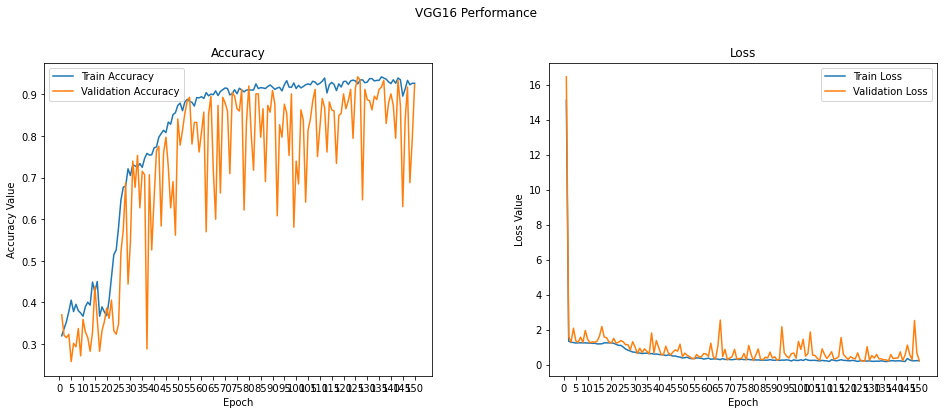

In [ ]:
plot_performance(history, "VGG16 Performance", 150)

In [ ]:
model = construct_model_VGG16()
model.load_weights(model_vgg_path)

In [ ]:
model.evaluate(data_gen.flow(X_train,Y_train,batch_size=32))

46/46 [==============================] - 27s 579ms/step - loss: 0.1794 - accuracy: 0.9444


[0.17942650616168976, 0.9443681240081787]

In [ ]:
model.evaluate(X_val,Y_val)

12/12 [==============================] - 3s 250ms/step - loss: 0.2043 - accuracy: 0.9342


[0.20429882407188416, 0.9342465996742249]

In [ ]:
predictions = model.predict(X_test)
df_pred  = pd.DataFrame(predictions, columns = ['healthy','multiple_diseases','rust','scab'])
results = {'image_id' : test.image_id,
            'healthy' : df_pred.healthy,
            'multiple_diseases' : df_pred.multiple_diseases,
            'rust' : df_pred.rust,
            'scab' : df_pred.scab
          }
df_results_cnn = pd.DataFrame(results)
df_results_cnn.to_csv('submissionVGG.csv',index=False)

In [ ]:
confusion_matrix(model, X_val, Y_val)

Confusion Matrix

[[ 99   0   1   0]
 [  1   6   9   2]
 [  1   0 119   0]
 [  8   1   1 117]]

Classification Report

                   precision    recall  f1-score   support

          healthy       0.91      0.99      0.95       100
multiple_diseases       0.86      0.33      0.48        18
             rust       0.92      0.99      0.95       120
             scab       0.98      0.92      0.95       127

         accuracy                           0.93       365
        macro avg       0.92      0.81      0.83       365
     weighted avg       0.93      0.93      0.93       365



### ResNet50

In [ ]:
def residual_block(X_start, filters, name, reduce=False, res_conv2d=False):
    nb_filters_1, nb_filters_2, nb_filters_3 = filters
    strides_1 = [2, 2] if reduce else [1, 1]

    X = Conv2D(filters=nb_filters_1, kernel_size=[1, 1], strides=strides_1, padding='same', name=name)(X_start)
    X = BatchNormalization()(X)  # default axis-1 is ok
    X = Activation('relu')(X)

    X = Conv2D(filters=nb_filters_2, kernel_size=[3, 3], strides=[1, 1], padding='same')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=nb_filters_3, kernel_size=[1, 1], strides=[1, 1], padding='same')(X)
    X = BatchNormalization()(X)

    if res_conv2d:
        X_res = Conv2D(filters=nb_filters_3, kernel_size=[1, 1], strides=strides_1, padding='same')(X_start)
        X_res = BatchNormalization()(X_res)
    else:
        X_res = X_start

    X = add([X, X_res])
    X = Activation('relu')(X)
    return X

def construct_model_ResNet50_1() :
    X_input = Input(shape=(img_size,img_size,3))

    # conv1
    X = Conv2D(filters=64, kernel_size=[3, 3], strides=[2, 2], padding='same', name='conv1')(X_input)
    X = BatchNormalization(name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D([3, 3], strides=[2, 2])(X)

    # conv2_x
    X = residual_block(X, filters=[64, 64, 256], name='conv2_a', reduce=False, res_conv2d=True)
    X = residual_block(X, filters=[64, 64, 256], name='conv2_b')
    X = residual_block(X, filters=[64, 64, 256], name='conv2_c')

    # conv3_x
    X = residual_block(X, filters=[128, 128, 512], name='conv3_a', reduce=True, res_conv2d=True)
    X = residual_block(X, filters=[128, 128, 512], name='conv3_b')
    X = residual_block(X, filters=[128, 128, 512], name='conv3_c')
    X = residual_block(X, filters=[128, 128, 512], name='conv3_d')

    # conv4_x
    X = residual_block(X, filters=[256, 256, 1024], name='conv4_a', reduce=True, res_conv2d=True)
    X = residual_block(X, filters=[256, 256, 1024], name='conv4_b')
    X = residual_block(X, filters=[256, 256, 1024], name='conv4_c')
    X = residual_block(X, filters=[256, 256, 1024], name='conv4_d')
    X = residual_block(X, filters=[256, 256, 1024], name='conv4_e')
    X = residual_block(X, filters=[256, 256, 1024], name='conv4_f')
    
    # conv5_x
    X = residual_block(X, filters=[512, 512, 2048], name='conv5_a', reduce=True, res_conv2d=True)
    X = residual_block(X, filters=[512, 512, 2048], name='conv5_b')
    X = residual_block(X, filters=[512, 512, 2048], name='conv5_c')

    X = GlobalAveragePooling2D()(X)
    X = Dense(512,activation='relu')(X)
    X = Dropout(0.3)(X)
    X = Dense(256,activation='relu')(X)
    X = Dense(4,activation='softmax')(X)

    model = Model(inputs=X_input, outputs=X)
    
    model.compile(optimizer='Adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])
    
    return model  

In [ ]:
model = construct_model_ResNet50_1()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 150, 150, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 150, 150, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, 150, 150, 64) 0           bn_conv1[0][0]                   
______________________________________________________________________________________________

In [ ]:
start_time = time.time()
history = model.fit_generator(data_gen.flow(X_train,Y_train,batch_size=32),
                    steps_per_epoch = X_train.shape[0] // 32,
                    epochs = 150,
                    verbose = True,
                    validation_data= (X_val,Y_val),
                    callbacks = [checkpoint_resnet1]
                   )
end_time = time.time()
print('Run time: %f ms' % ((end_time - start_time) * 1000))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/150
45/45 [==============================] - 76s 808ms/step - loss: 1.8028 - accuracy: 0.3518 - val_loss: 1.3171 - val_accuracy: 0.3315

Epoch 00001: val_loss improved from inf to 1.31714, saving model to /content/gdrive/My Drive/Machine Learning/data/best_model_resnet_50.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/150
45/45 [==============================] - 33s 732ms/step - loss: 1.3543 - accuracy: 0.3392 - val_loss: 1.2644 - val_accuracy: 0.3479

Epoch 00002: val_loss improved from 1.31714 to 1.26437, saving model to /content/gdrive/My Drive/Machine Learning/data/best_model_resnet_50.h5
Epoch 3/150
45/45 [==============================] - 34s 742ms/step - loss: 1.2421 - accuracy: 0.3687 - val_loss: 1.3242 - val_accuracy: 0.3479

Epoch 00003: val_loss did not improve from 1.26437
Epoch 4/150
45/45 [==============================] - 33s 724ms/step - loss: 1.2257 - accuracy: 0.3834 - val_loss: 1.3528 - val_accuracy: 0.3479

Epoch 00004: val_loss did not improve from 1.26437
Epoch 5/150
45/45 [==============================] - 33s 732ms/step - loss: 1.2095 - accuracy: 0.3989 - val_loss: 1.3117 - val_accuracy: 0.3288

Epoch 00005: val_loss did not improve from 1.26437
Epoch 6/150
45/45 [==============================] - 33s 735ms/step - loss: 1.1891 - accuracy: 0.4473 - val_loss: 1.3068 - v

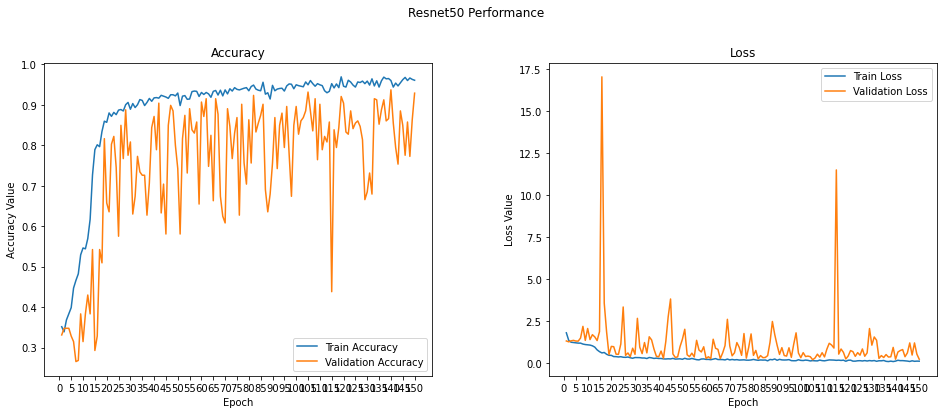

In [ ]:
plot_performance(history, "Resnet50 Performance", 150)

In [ ]:
model = construct_model_ResNet50_1()
model.load_weights(model_resnet1_path)

In [ ]:
model.evaluate(data_gen.flow(X_train,Y_train,batch_size=32))

46/46 [==============================] - 26s 530ms/step - loss: 0.1645 - accuracy: 0.9341


[0.16445645689964294, 0.9340659379959106]

In [ ]:
model.evaluate(X_val,Y_val)

12/12 [==============================] - 3s 169ms/step - loss: 0.2003 - accuracy: 0.9315


[0.20030994713306427, 0.931506872177124]

In [ ]:
predictions = model.predict(X_test)
df_pred  = pd.DataFrame(predictions, columns = ['healthy','multiple_diseases','rust','scab'])
results = {'image_id' : test.image_id,
            'healthy' : df_pred.healthy,
            'multiple_diseases' : df_pred.multiple_diseases,
            'rust' : df_pred.rust,
            'scab' : df_pred.scab
          }
df_results_cnn = pd.DataFrame(results)
df_results_cnn.to_csv('submissionResnet50.csv',index=False)

In [ ]:
confusion_matrix(model, X_val, Y_val)

Confusion Matrix

[[ 95   3   0   2]
 [  1  16   0   1]
 [  1  11 108   0]
 [  5   1   0 121]]

Classification Report

                   precision    recall  f1-score   support

          healthy       0.93      0.95      0.94       100
multiple_diseases       0.52      0.89      0.65        18
             rust       1.00      0.90      0.95       120
             scab       0.98      0.95      0.96       127

         accuracy                           0.93       365
        macro avg       0.86      0.92      0.88       365
     weighted avg       0.95      0.93      0.94       365



### Inception V3

In [ ]:
def transfer_learning_InceptionV3() :
    base_model=InceptionV3(weights='imagenet',include_top=False,input_shape=(img_size,img_size,3))
    base_model.trainable = True
    for layer in base_model.layers[:-3] :
        layer.trainable = True
    x=base_model.output
    x=GlobalAveragePooling2D()(x)
    x=Dense(512,activation='relu')(x)
    x=Dropout(0.3)(x)
    x=Dense(256,activation='relu')(x)
    preds=Dense(4,activation='softmax')(x)
    model=Model(inputs=base_model.input,outputs=preds)
    model.compile(optimizer='Adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])
    return model  

In [ ]:
model = transfer_learning_InceptionV3()
model.summary()

87916544/87910968 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_____________________________

In [ ]:
start_time = time.time()
history = model.fit_generator(data_gen.flow(X_train,Y_train,batch_size=32),
                    steps_per_epoch = X_train.shape[0] // 32,
                    epochs = 150,
                    verbose = True,
                    validation_data= (X_val,Y_val),
                    callbacks = [checkpoint_inception]
                   )
end_time = time.time()
print('Run time: %f ms' % ((end_time - start_time) * 1000))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/150
45/45 [==============================] - 77s 778ms/step - loss: 1.1904 - accuracy: 0.4361 - val_loss: 101357.4766 - val_accuracy: 0.3288

Epoch 00001: val_loss improved from inf to 101357.47656, saving model to /content/gdrive/My Drive/Machine Learning/data/best_model_inceptionV3.h5
Epoch 2/150
45/45 [==============================] - 31s 677ms/step - loss: 0.7541 - accuracy: 0.6264 - val_loss: 10.3706 - val_accuracy: 0.3534

Epoch 00002: val_loss improved from 101357.47656 to 10.37057, saving model to /content/gdrive/My Drive/Machine Learning/data/best_model_inceptionV3.h5
Epoch 3/150
45/45 [==============================] - 32s 700ms/step - loss: 0.6933 - accuracy: 0.7121 - val_loss: 4245.7339 - val_accuracy: 0.3288

Epoch 00003: val_loss did not improve from 10.37057
Epoch 4/150
45/45 [==============================] - 30s 666ms/step - loss: 0.5510 - accuracy: 0.8244 - val_loss: 1.4873 - val_accuracy: 0.3589

Epoch 00004: val_loss improved from 10.37057 to 1.48732, savin

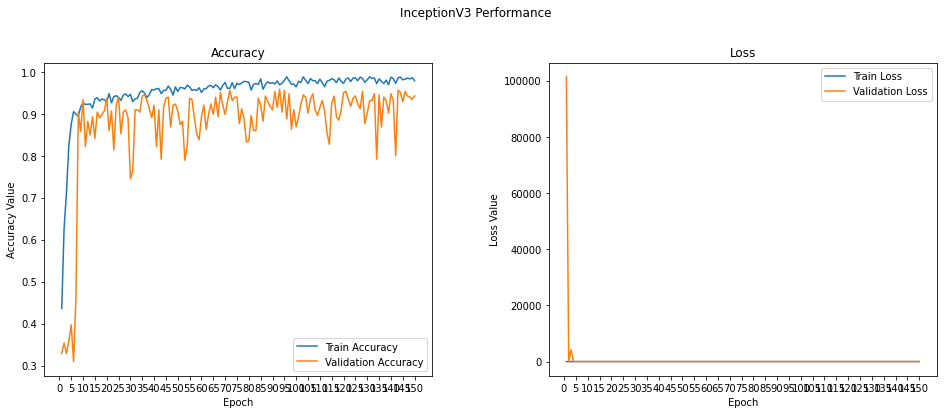

In [ ]:
plot_performance(history, "InceptionV3 Performance", 150)

In [ ]:
model.load_weights(model_inception_path)

In [ ]:
model.evaluate(data_gen.flow(X_train,Y_train,batch_size=32))

46/46 [==============================] - 25s 517ms/step - loss: 0.0784 - accuracy: 0.9746


[0.0784090906381607, 0.9745879173278809]

In [ ]:
model.evaluate(X_val,Y_val)

12/12 [==============================] - 1s 121ms/step - loss: 0.1666 - accuracy: 0.9452


[0.166604682803154, 0.9452054500579834]

In [ ]:
predictions = model.predict(X_test)
df_pred  = pd.DataFrame(predictions, columns = ['healthy','multiple_diseases','rust','scab'])
results = {'image_id' : test.image_id,
            'healthy' : df_pred.healthy,
            'multiple_diseases' : df_pred.multiple_diseases,
            'rust' : df_pred.rust,
            'scab' : df_pred.scab
          }
df_results_cnn = pd.DataFrame(results)
df_results_cnn.to_csv('submissionInceptionV3.csv',index=False)

In [ ]:
confusion_matrix(model, X_val, Y_val)

Confusion Matrix

[[ 98   0   1   1]
 [  1  11   5   1]
 [  0   1 119   0]
 [  5   5   0 117]]

Classification Report

                   precision    recall  f1-score   support

          healthy       0.94      0.98      0.96       100
multiple_diseases       0.65      0.61      0.63        18
             rust       0.95      0.99      0.97       120
             scab       0.98      0.92      0.95       127

         accuracy                           0.95       365
        macro avg       0.88      0.88      0.88       365
     weighted avg       0.95      0.95      0.94       365



### EfficentNet

In [ ]:
def transfer_learning_EfficientNet() :
    base_model = efn.EfficientNetB3(weights = 'imagenet', include_top=False, input_shape = (img_size,img_size,3))
    base_model.trainable = True
    for layer in base_model.layers[:-3]:
        layer.trainable = True
    x=base_model.output
    x=GlobalAveragePooling2D()(x)
    x=Dense(512,activation='relu')(x)
    x=Dropout(0.3)(x)
    x=Dense(256,activation='relu')(x)
    preds=Dense(4,activation='softmax')(x)
    model=Model(inputs=base_model.input,outputs=preds)
    model.compile(optimizer='Adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])
    return model  

In [ ]:
model = transfer_learning_EfficientNet()
model.summary()

44113920/44107200 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 150, 150, 40) 1080        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 150, 150, 40) 160         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 150, 150, 40) 0           stem_bn[0][0]                    
_____________________________

In [ ]:
start_time = time.time()
history = model.fit_generator(data_gen.flow(X_train,Y_train,batch_size=24),
                    steps_per_epoch = X_train.shape[0] // 24,
                    epochs = 150,
                    verbose = True,
                    validation_data= (X_val,Y_val),
                    callbacks = [checkpoint_eff]
                   )
end_time = time.time()
print('Run time: %f ms' % ((end_time - start_time) * 1000))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/150
60/60 [==============================] - 101s 923ms/step - loss: 0.5779 - accuracy: 0.8101 - val_loss: 4.4215 - val_accuracy: 0.5808

Epoch 00001: val_loss improved from inf to 4.42147, saving model to /content/gdrive/My Drive/Machine Learning/data/best_model_eff.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/150
60/60 [==============================] - 49s 818ms/step - loss: 0.3326 - accuracy: 0.8973 - val_loss: 1.3471 - val_accuracy: 0.8438

Epoch 00002: val_loss improved from 4.42147 to 1.34714, saving model to /content/gdrive/My Drive/Machine Learning/data/best_model_eff.h5
Epoch 3/150
60/60 [==============================] - 50s 826ms/step - loss: 0.3443 - accuracy: 0.9028 - val_loss: 1.4014 - val_accuracy: 0.8055

Epoch 00003: val_loss did not improve from 1.34714
Epoch 4/150
60/60 [==============================] - 50s 833ms/step - loss: 0.2835 - accuracy: 0.9232 - val_loss: 0.9667 - val_accuracy: 0.6603

Epoch 00004: val_loss improved from 1.34714 to 0.96667, saving model to /content/gdrive/My Drive/Machine Learning/data/best_model_eff.h5
Epoch 5/150
60/60 [==============================] - 50s 827ms/step - loss: 0.2470 - accuracy: 0.9204 - val_loss: 0.5523 - val_accuracy: 0.8411

Epoch 00005: val_loss improved from 0.96667 to 0.55229, saving model to /content/gdrive/My Driv

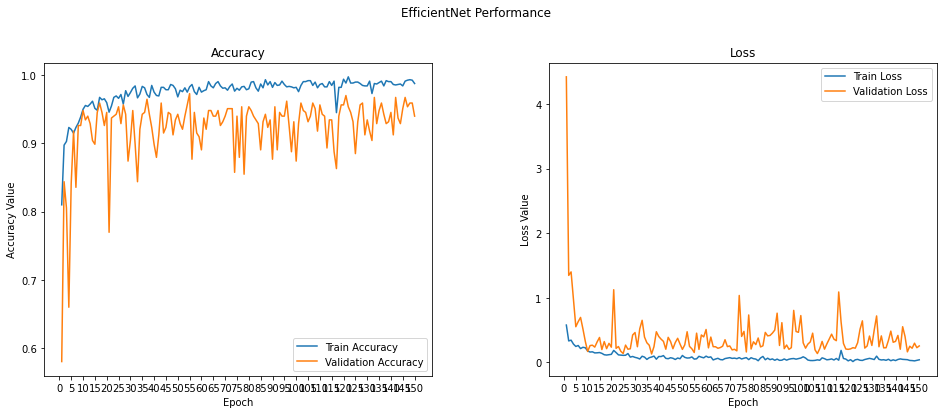

In [ ]:
plot_performance(history, "EfficientNet Performance", 150)

In [ ]:
model.load_weights(model_eff_path)

In [ ]:
model.evaluate(data_gen.flow(X_train,Y_train,batch_size=32))

46/46 [==============================] - 27s 553ms/step - loss: 0.0624 - accuracy: 0.9808


[0.062357254326343536, 0.9807692170143127]

In [ ]:
model.evaluate(X_val,Y_val)

12/12 [==============================] - 2s 194ms/step - loss: 0.1303 - accuracy: 0.9644


[0.13030143082141876, 0.9643835425376892]

In [ ]:
predictions = model.predict(X_test)
df_pred  = pd.DataFrame(predictions, columns = ['healthy','multiple_diseases','rust','scab'])
results = {'image_id' : test.image_id,
            'healthy' : df_pred.healthy,
            'multiple_diseases' : df_pred.multiple_diseases,
            'rust' : df_pred.rust,
            'scab' : df_pred.scab
          }
df_results_cnn = pd.DataFrame(results)
df_results_cnn.to_csv('submissionEfficientNet.csv',index=False)

In [ ]:
confusion_matrix(model, X_val, Y_val)

Confusion Matrix

[[100   0   0   0]
 [  1  14   2   1]
 [  0   1 119   0]
 [  8   0   0 119]]

Classification Report

                   precision    recall  f1-score   support

          healthy       0.92      1.00      0.96       100
multiple_diseases       0.93      0.78      0.85        18
             rust       0.98      0.99      0.99       120
             scab       0.99      0.94      0.96       127

         accuracy                           0.96       365
        macro avg       0.96      0.93      0.94       365
     weighted avg       0.97      0.96      0.96       365

